In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformer_lens.hook_points import HookedRootModule, HookPoint
import einops

C:\Users\bened\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CirclePointsBatcher:
    """ Simple batcher to create test and train data for a simple classification model 
    z = {x^2 + y^2 < 1: 1 
         else:          0} 
    ...where (x, y) in [-2, 2]
    """

    @staticmethod
    def circle_label_tensor(X):
        # X shape: [N, 2], with columns x and y
        return ((X[..., 0] ** 2 + X[..., 1] ** 2) < 1).long()

    def __init__(self, device, n_points, frac_train, n_sample_default=None):
        self.device = device

        # Sample uniformly from [-2, 2] x [-2, 2]
        X_all = 4 * torch.rand([n_points, 2]) - 2
        Y_all = CirclePointsBatcher.circle_label_tensor(X_all)

        # Shuffle indices
        i_shuffled = torch.randperm(n_points)
        X_all, Y_all = X_all[i_shuffled], Y_all[i_shuffled]

        i_test = int(frac_train * n_points)

        self.X_train = X_all[:i_test].to(self.device)
        self.Y_train = Y_all[:i_test].to(self.device)
        self.n_train = len(self.X_train)

        self.X_test = X_all[i_test:].to(self.device)
        self.Y_test = Y_all[i_test:].to(self.device)
        self.n_test = len(self.X_test)

        self.n_sample_default = n_sample_default

    def __call__(self, test_train, n_sample=None):
        if test_train == "train":
            X = self.X_train
            Y = self.Y_train
            n_X = self.n_train
        elif test_train == "test":
            X = self.X_test
            Y = self.Y_test
            n_X = self.n_test
        else:
            raise ValueError(
                f"`test_train` {test_train} is invalid. Can only be 'test' or 'train'"
            )

        if n_sample is None:
            n_sample = self.n_sample_default

        assert n_sample is not None, "cannot have n_sample and n_sample_default = None"
        assert n_sample <= n_X, f"n_sample = {n_sample} is too large (> {n_X})"

        i_shuffled = torch.randperm(n_X)[:n_sample]

        return X[i_shuffled].to(self.device), Y[i_shuffled].to(self.device)


In [3]:
# def plot_model_contour(model, device, xlim=(-2, 2), ylim=(-2, 2), resolution=100, ax=None, fig=None):
#     # Make a grid
#     xs = torch.linspace(xlim[0], xlim[1], resolution)
#     ys = torch.linspace(ylim[0], ylim[1], resolution)
#     X, Y = torch.meshgrid(xs, ys, indexing="ij")

#     # Flatten grid into [N, 2] for model input
#     grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)

#     # Run model
#     with torch.no_grad():
#         Z = model(grid_points).cpu().numpy()

#     # Reshape back to grid
#     Z = Z.reshape(resolution, resolution)

#     # Plot as filled contour
#     if ax is None:
#         ax = plt.gca()
    
#     cont = ax.contourf(X.numpy(), Y.numpy(), Z, levels=50, cmap="coolwarm", alpha=0.8)
#     cbar = plt.colorbar(cont, ax=ax, label="Model output")

#     # Optional: contour line at 0.5 (for classification boundary)
#     ax.contour(X.numpy(), Y.numpy(), Z, levels=[0.5], colors="black")

#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_title("Model decision surface")
#     plt.show()

# def plot_model_contour(model, device, xlim=(-2, 2), ylim=(-2, 2), resolution=100, ax=None, fig=None, batch_size=4096):
#     import numpy as np
#     # prepare grid
#     xs = torch.linspace(xlim[0], xlim[1], resolution)
#     ys = torch.linspace(ylim[0], ylim[1], resolution)
#     X, Y = torch.meshgrid(xs, ys, indexing="ij")
#     grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)

#     # get outputs (batched for memory)
#     with torch.no_grad():
#         outs = []
#         N = grid_points.shape[0]
#         for i in range(0, N, batch_size):
#             batch = grid_points[i:i+batch_size]
#             out = model(batch)
#             outs.append(out.cpu())
#         out = torch.cat(outs, dim=0).numpy()

#     # prefer probability for class 1 if 2-d output
#     if out.ndim == 2 and out.shape[1] >= 2:
#         Z = out[:, 1]
#     else:
#         Z = out.flatten()
#     Z = Z.reshape(resolution, resolution)

#     # resolve axes/figure
#     if ax is None:
#         fig = fig or plt.gcf()
#         ax = fig.gca()
#     else:
#         fig = fig or ax.figure

#     # remove previous contour/collection artists on this axis (prevents stacking)
#     for coll in list(ax.collections) + list(getattr(ax, "images", [])):
#         try:
#             coll.remove()
#         except Exception:
#             pass

#     # clip and plot with fixed color scale 0..1
#     Z_display = np.clip(Z, 0.0, 1.0)
#     norm = plt.Normalize(vmin=0.0, vmax=1.0)
#     levels = np.linspace(0.0, 1.0, 51)
#     cont = ax.contourf(X.numpy(), Y.numpy(), Z_display, levels=levels, cmap="coolwarm", norm=norm, alpha=0.85)

#     # add colorbar to the same figure
#     cbar = fig.colorbar(cont, ax=ax, label="Model output (prob class=1)")
#     cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])

#     # draw 0.5 contour only if it exists in range
#     zmin, zmax = float(Z.min()), float(Z.max())
#     if zmin < 0.5 < zmax:
#         ax.contour(X.numpy(), Y.numpy(), Z, levels=[0.5], colors="black", linewidths=1.0)
#     else:
#         ax.text(0.02, 0.98, f"No 0.5 contour (probs in [{zmin:.3f}, {zmax:.3f}])",
#                 transform=ax.transAxes, va="top", ha="left",
#                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_title("Model decision surface")

#     # update drawing (works in notebooks and interactive backends)
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     plt.pause(0.001)

import matplotlib.pyplot as plt
import torch
import numpy as np
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

plt.ion()  # interactive mode

def plot_model_contour(model, device, xlim=(-2, 2), ylim=(-2, 2), resolution=100, ax=None, fig=None, batch_size=None):
    # prepare grid
    X, Y, grid_points = prepare_grid(xlim, ylim, resolution, device)

    # get outputs (batched)
    with torch.no_grad():
        if batch_size is None:
            out = model(grid_points)
        else:
            outs = []
            N = grid_points.shape[0]
            for i in range(0, N, batch_size):
                batch = grid_points[i:i+batch_size]
                out = model(batch)
            outs.append(out.cpu())
            out = torch.cat(outs, dim=0).numpy()

    if out.ndim == 2 and out.shape[1] >= 2:
        Z = out[:, 1]
    else:
        Z = out.flatten()
    Z = Z.reshape(resolution, resolution)

    fig, ax = plot_contour(X, Y, Z, 
                           ax=ax, fig=fig,
                           clip=True, levels=np.linspace(0.0, 1.0, 51))

    return fig, ax

def prepare_grid(xlim, ylim, resolution, device):
    xs = torch.linspace(xlim[0], xlim[1], resolution)
    ys = torch.linspace(ylim[0], ylim[1], resolution)
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
    return X, Y, grid_points

def plot_contour(X, Y, Z, ax=None, fig=None, clip=False, levels=51, xlabel="x", ylabel="y", title=""):
    # figure/axes setup
    if ax is None:
        fig = fig or plt.gcf()
        ax = fig.gca()
    else:
        fig = fig or ax.figure

    ax.clear()  # clear previous contour

    # plot contour
    Z_display = np.clip(Z, 0.0, 1.0) if clip else Z
    cont = ax.contourf(X.numpy(), Y.numpy(), Z_display, levels=levels, cmap="coolwarm", alpha=0.85)

    # draw 0.5 contour if in range
    zmin, zmax = Z.min(), Z.max()
    if zmin < 0.5 < zmax:
        ax.contour(X.numpy(), Y.numpy(), Z, levels=[0.5], colors="black", linewidths=1.0)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # update figure
    clear_output(wait=True)
    display(fig)
    plt.close(fig)

    return fig, ax

def plot_surface(X, Y, Z, ax=None, fig=None, clip=False, xlabel="x", ylabel="y", zlabel="z", title=""):
    # Setup figure and axis
    if ax is None:
        fig = fig or plt.figure()
        # use explicit positional args for add_subplot so 'projection' is accepted robustly
        try:
            ax3 = fig.add_subplot(1, 1, 1, projection="3d")
        except TypeError:
            # fallback: some environments prefer plt.axes(...) or plt.gca with projection
            ax3 = plt.axes(projection="3d")
    elif hasattr(ax, "zaxis"):
        ax3 = ax
    else:
        # preserve location and replace ax with a 3D axes
        pos = ax.get_position()        # bounding box in figure coords
        fig = ax.figure
        fig.delaxes(ax)

        # option A: if ax came from a GridSpec/subplot, reuse the SubplotSpec
        try:
            spec = ax.get_subplotspec()
            ax3 = fig.add_subplot(spec, projection="3d")
        except Exception:
            # fallback: add by position
            ax3 = fig.add_axes(pos, projection="3d")

    Z_display = np.clip(Z, 0.0, 1.0) if clip else Z
    surf = ax3.plot_surface(X.numpy(), Y.numpy(), Z_display, cmap="coolwarm", edgecolor="none")

    ax3.set_xlabel(xlabel)
    ax3.set_ylabel(ylabel)
    ax3.set_zlabel(zlabel)
    ax3.set_title(title)

    # update figure
    clear_output(wait=True)
    display(fig)
    plt.close(fig)

    return fig, ax


In [12]:
class CircleModel(HookedRootModule):
    """
    Simple network with 2D input, N_hidden hidden layers, ReLU, softmax and 2D output
    """

    # def __init__(self, N_hidden):
    #     super().__init__()

    #     self.N_hidden = N_hidden
    #     self.d_in = 2
    #     self.d_out = 2

        
    #     self.h_hook_in = HookPoint()     # before first layer

    #     self.lin1 = nn.Linear(in_features=self.d_in, out_features=self.N_hidden)
    #     self.h_activation1 = HookPoint()    # after 1st hidden layer

    #     self.lin2 = nn.Linear(in_features=self.N_hidden, out_features=self.N_hidden)
    #     self.h_activation2 = HookPoint()    # after 2nd hidden layer

    #     self.lin3 = nn.Linear(in_features=self.N_hidden, out_features=self.d_out)
    #     self.h_post_ffwd = HookPoint()    # after final layer

    #     self.softmax = nn.Softmax(dim=1)
    #     self.h_output = HookPoint()

    #     self.activation_fn = nn.GELU()
    #     # other alternatives are ReLU and LeakyReLU, but they are not so good and the loss remains > 0.5 on very small models

    #     self.setup()

    # def forward(self, x):
    #     self.h_hook_in(x)
    #     x = self.h_activation1(self.activation_fn(self.lin1(x)))
    #     x = self.h_activation2(self.activation_fn(self.lin2(x)))
    #     x = self.h_post_ffwd(self.lin3(x))
    #     logits = self.h_output(self.softmax(x))

    #     return logits
    
    def __init__(self, N_hidden, activation_fn=torch.relu):
        super().__init__()

        self.N_hidden = N_hidden
        self.d_in = 2
        self.d_out = 2


        self.h_hook_in = HookPoint()     # before first layer

        self.lin1 = nn.Linear(in_features=self.d_in, out_features=self.N_hidden)
        self.h_activation = HookPoint()    # after 1st hidden layer

        self.lin2 = nn.Linear(in_features=self.N_hidden, out_features=self.d_out)
        self.h_post_ffwd = HookPoint()    # after final layer

        self.softmax = nn.Softmax(dim=1)
        self.h_output = HookPoint()

        self.activation_fn = activation_fn
        # other alternatives are ReLU and LeakyReLU, but they are not so good and the loss remains > 0.5 on very small models

        self.setup()

    def forward(self, x):
        self.h_hook_in(x)
        x = self.h_activation(self.activation_fn(self.lin1(x)))
        x = self.h_post_ffwd(self.lin2(x))
        logits = self.h_output(self.softmax(x))

        return logits

    def predict(self, x):
        logits = self(x)
        return logits.argmax(dim=1).float()
    
    def confidence_true(self, x):
        logits = self(x)
        return logits[:, 1]

def std_normal(x):
    return torch.exp(-0.5 * x**2) / np.sqrt(2 * torch.pi)

In [36]:
device = "cpu" if torch.cuda.is_available() else "cpu"
torch.manual_seed(3)

LR = 1e-4
N_EPOCHS = 10000
BATCH_SIZE = 3000
N_HIDDEN = 2
activation_fn = nn.GELU()
activation_fn_name = "GELU"


model = CircleModel(N_hidden=N_HIDDEN, activation_fn=activation_fn)
# model.load_state_dict(torch.load(f"models_{activation_fn_name}/circle_model_n={N_HIDDEN},l=1", map_location=device))
batcher = CirclePointsBatcher(device=device, n_points=10000, frac_train=1, n_sample_default=BATCH_SIZE)
optimiser = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

fig, ax = plt.subplots()

X_train, y_train = batcher("train", n_sample=1)

logits, activations = model.run_with_cache(X_train)

i_disp = 10

for i in range(N_EPOCHS):
    if not i % i_disp:
        plot_model_contour(model.confidence_true, device, ax=ax, fig=fig)
    
    model.train()

    X_train, y_train = batcher("train")
    logits = model(X_train)
    loss = loss_fn(logits, y_train)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if not i % i_disp:
        print(i, loss.item())


KeyboardInterrupt: 

In [29]:
import os
os.makedirs(f"models_{activation_fn_name}", exist_ok=True)
torch.save(model.state_dict(), f"models_{activation_fn_name}/circle_model_n={N_HIDDEN},l=1")

In [ ]:
list(model.state_dict())

['lin1.weight', 'lin1.bias', 'lin2.weight', 'lin2.bias']

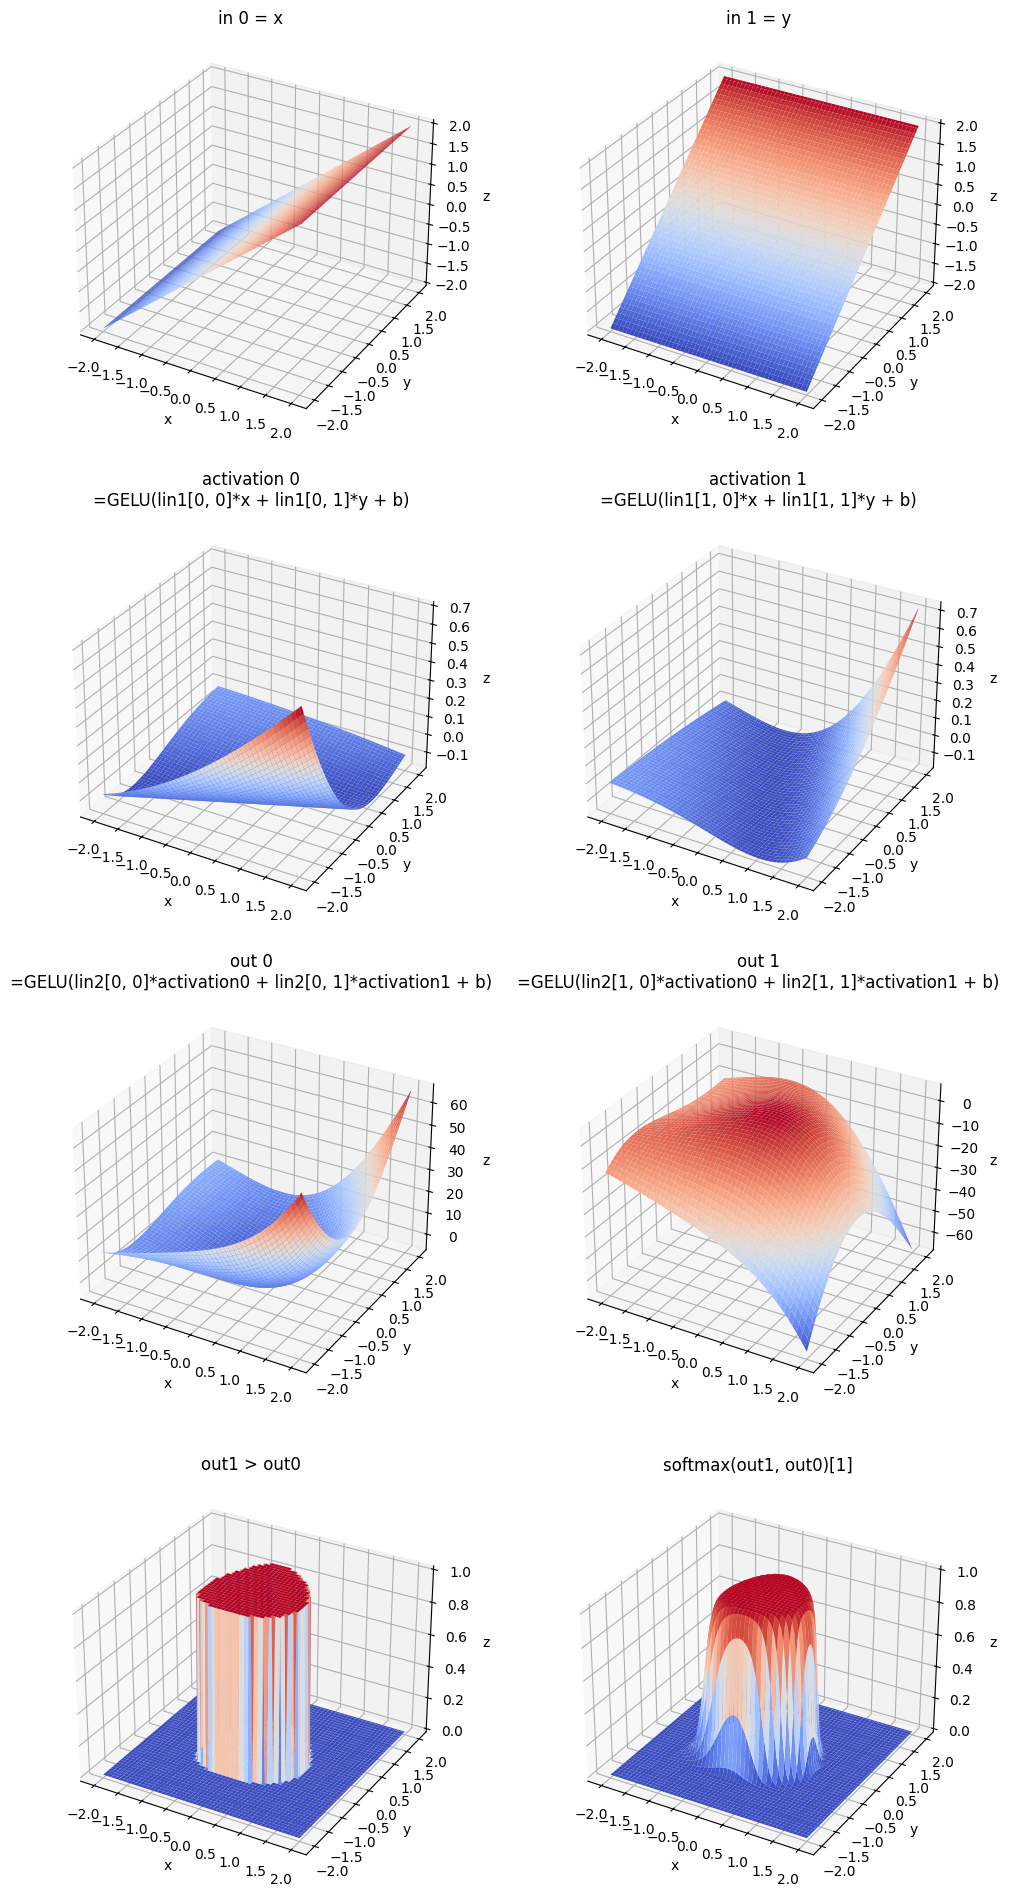

(<Figure size 1200x2400 with 8 Axes>, <Axes: >)

In [ ]:
model = CircleModel(N_hidden=N_HIDDEN, activation_fn=activation_fn)
model.load_state_dict(torch.load(f"models_{activation_fn_name}/circle_model_n={N_HIDDEN},l=1", map_location=device))
# plot_model_contour(model.confidence_true, device, ax=ax, fig=fig)
# plot_model_contour(lambda x: model.lin1(x)[:, 1], device)

resolution = 100
X, Y, grid_points = prepare_grid((-2, 2), (-2, 2), resolution, device)
# model.activation_fn = nn.ReLU()   # for visualization purposes only
logits, activations = model.run_with_cache(grid_points)
fig, axes = plt.subplots(4, N_HIDDEN, figsize=(12, 24))


inputs = einops.rearrange(activations["h_hook_in"], "(b1 b2) d -> b1 b2 d", b1=resolution, b2=resolution)
plot_surface(X, Y, inputs[..., 0], ax=axes[0, 0], fig=fig, title="in 0 = x")
plot_surface(X, Y, inputs[..., 1], ax=axes[0, 1], fig=fig, title="in 1 = y")

h_activations = einops.rearrange(activations["h_activation"], "(b1 b2) d -> b1 b2 d", b1=resolution, b2=resolution)
for i in range(N_HIDDEN):
    plot_surface(X, Y, h_activations[..., i], ax=axes[1, i], fig=fig, 
                title=f"activation {i}\n={activation_fn_name}(lin1[{i}, 0]*x + lin1[{i}, 1]*y + b)")
# plot_surface(X, Y, h_activations[..., 1], ax=axes[1, 1], fig=fig, 
#              title=f"activation 1\n={activation_fn_name}(lin1[1, 0]*x + lin1[1, 1]*y + b)")

h_post_ffwd = einops.rearrange(activations["h_post_ffwd"], "(b1 b2) d -> b1 b2 d", b1=resolution, b2=resolution)
for i in range(2):
    plot_surface(X, Y, h_post_ffwd[..., i], ax=axes[2, i], fig=fig, 
                title=f"out {i}\n={activation_fn_name}(lin2[{i}, 0]*activation0 + lin2[{i}, 1]*activation1 + b)")
# plot_surface(X, Y, h_post_ffwd[..., 1], ax=axes[2, 1], fig=fig, 
#              title=f"out 1\n={activation_fn_name}(lin2[1, 0]*activation0 + lin2[1, 1]*activation1 + b)")

argmax = h_post_ffwd[..., 1] > h_post_ffwd[..., 0]
plot_surface(X, Y, argmax, ax=axes[3, 0], fig=fig, 
             title="out1 > out0")

h_output = einops.rearrange(activations["h_output"], "(b1 b2) d -> b1 b2 d", b1=resolution, b2=resolution)
# plot_surface(X, Y, h_output[..., 0], ax=axes[3, 0], fig=fig)
plot_surface(X, Y, h_output[..., 1], ax=axes[3, 1], fig=fig,
             title="softmax(out1, out0)[1]")

In [33]:
fig.savefig(f"plots/LayerActivations,l=1,n={N_HIDDEN},{activation_fn_name}.png")

In [ ]:
model.state_dict()

OrderedDict([('lin1.weight',
              tensor([[ 2.4332, -1.4403],
                      [ 0.1832, -0.0341],
                      [ 0.0926,  2.7244],
                      [-2.7750, -1.5115]])),
             ('lin1.bias', tensor([-0.7206, -0.5914, -0.6234, -0.6924])),
             ('lin2.weight',
              tensor([[ 1.9718,  0.3862,  1.7738,  1.9720],
                      [-1.8758, -0.2786, -1.9239, -1.3219]])),
             ('lin2.bias', tensor([-3.2251,  2.7304]))])

Observations (for a 1-layer, 2-neuron model):
* the GELU model is using the 'dip' where $x$ is _just_ less than zero ($x \approx -0.75$) to _enclose_ the unit circle with fewer neurons than if using ReLU
* this is shown most clearly in how the softmax uses the geometry of the two surfaces output by the MLP - the steep rise in the GELU function (for +ve input) is all on one side, whereas in ReLU the 'folds' would need to surround the origin
* this inspires the use of the standard normal as an alternative activation function (see fig. 3)
* this is also evidenced by the poor performance of the model when switching GeLU out for ReLU or LeakyReLU, however this is also due to the non-negligible difference in the function's values over the whole range [-2, 2] (ie. not just in a small neighbourhood around 0). This results in the offset of the MLP outputs being different

TODO: look at a std_normal() activation function

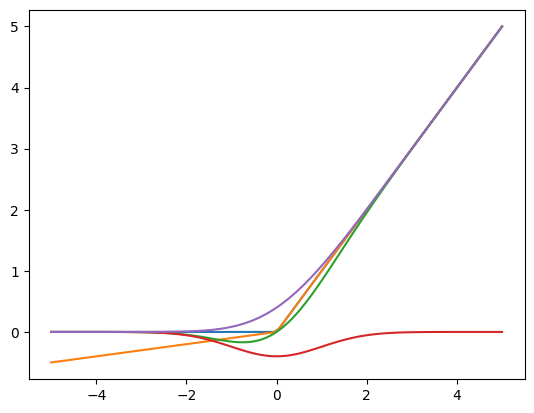

In [ ]:

def std_normal(x):
    return torch.exp(-0.5 * x**2) / np.sqrt(2 * torch.pi)

# testing ReLU, LeakyReLU and GELU
X = torch.linspace(-5, 5, 100)
Y_ReLU = torch.relu(X)
Y_LeakyReLU = torch.nn.functional.leaky_relu(X, negative_slope=0.1)
Y_GELU = torch.nn.functional.gelu(X)
Y_normal = -std_normal(X)
Y_ = Y_GELU + std_normal(X)
# Y_ = Y_GELU + X

plt.plot(X.numpy(), Y_ReLU.numpy(), label="ReLU")
plt.plot(X.numpy(), Y_LeakyReLU.numpy(), label="LeakyReLU")
plt.plot(X.numpy(), Y_GELU.numpy(), label="GELU")
plt.plot(X.numpy(), Y_normal.numpy(), label="normal")
plt.plot(X.numpy(), Y_.numpy(), label="")

In [ ]:
print(activations.keys())
def plot1D(tensor):
    plt.plot(tensor.detach().cpu().numpy().flatten())


plot1D(activations["h_activation1"])
plot1D(activations["h_activation2"])
plot1D(activations["h_post_ffwd"])
plot1D(activations["h_output"])


In [ ]:


# plot_model_contour(CirclePointsBatcher.circle_label_tensor, device)

